In [1]:
from data_common.notebook import *
import pandas as pd
from uk_ruc.create_la_data import create_con_data
from data_common.pandas.df_extensions.space import SpacePDAccessor as SpaceDataFrame
from data_common.dataset import get_dataset_df

In [2]:
ruc = pd.read_csv(Path("data", "packages", "uk_ruc", "composite_ruc.csv"))
ruc = ruc[["lsoa", "ukruc-3", "pop"]].set_index("lsoa")

# get this into the form of a sheet where the percentage of each con is urban, rural, and highly rural is a row

# this gets a file of all the overlaps lsoas and constituencies
df = (
    get_dataset_df(
        repo="2025-constituencies",
        package="geographic_overlaps",
        version="latest",
        file="LSOA11_PARL25_combo_overlap.csv",
    )
    .sort_values("percentage_overlap_pop", ascending=False)
    .drop_duplicates(subset=["LSOA11", "PARL25"], keep="first")
    .set_index("LSOA11")["PARL25"]
)

df = ruc.join(df, how="outer")
df["ukruc-3"] = df["ukruc-3"].map({0: "Urban", 1: "Rural", 2: "Highly rural"})
pt = df.pivot_table("pop", index="PARL25", columns=["ukruc-3"], aggfunc="sum").fillna(0)

df = pt.common.row_percentages()

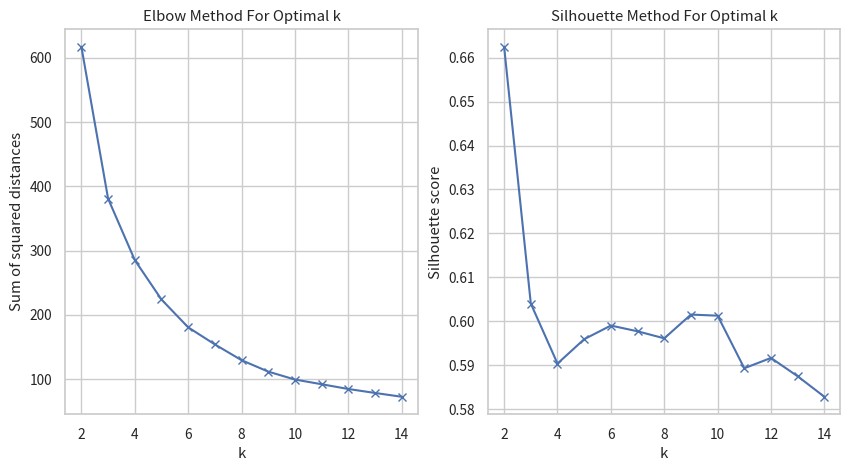

In [3]:
# now look to see if obvious clusters

c = SpaceDataFrame(df).cluster()
c.find_k()

Best bet looks like about 6 clusters

In [4]:
c.set_k(4).stats()

,count,%,random members
labels,,,
1,155,23.8,"[UKPARL.2025.MLE, UKPARL.2025.VOG, UKPARL.2025..."
2,74,11.4,"[UKPARL.2025.NNU, UKPARL.2025.WAK, UKPARL.2025..."
3,337,51.8,"[UKPARL.2025.LGT, UKPARL.2025.ESL, UKPARL.2025..."
4,84,12.9,"[UKPARL.2025.BRD, UKPARL.2025.SHD, UKPARL.2025..."


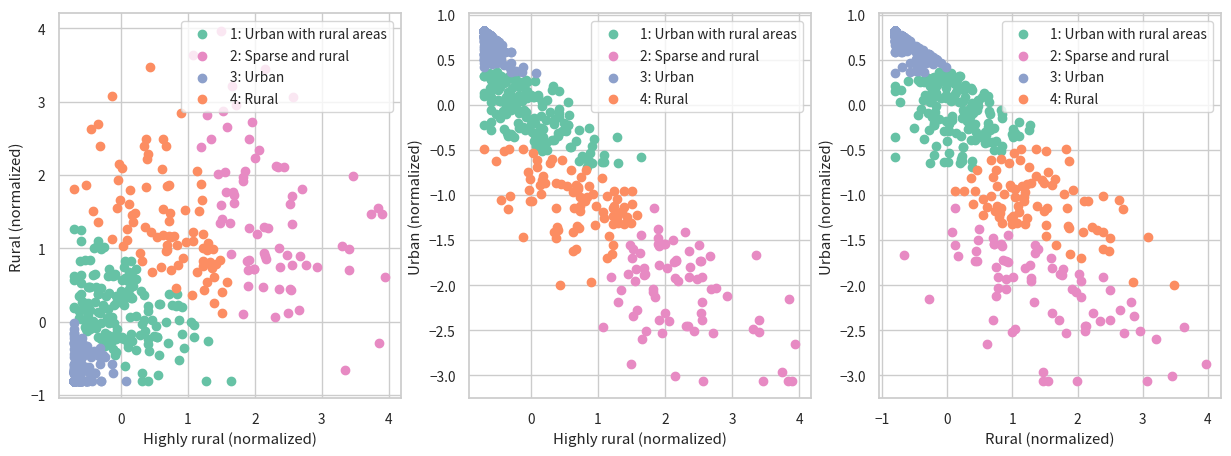

In [5]:
c.set_k(4).add_labels(
    {1: "Urban with rural areas", 2: "Sparse and rural", 3: "Urban", 4: "Rural"}
).plot()

These seem ok grouping (although obviously at the margins the limit is not hard). 

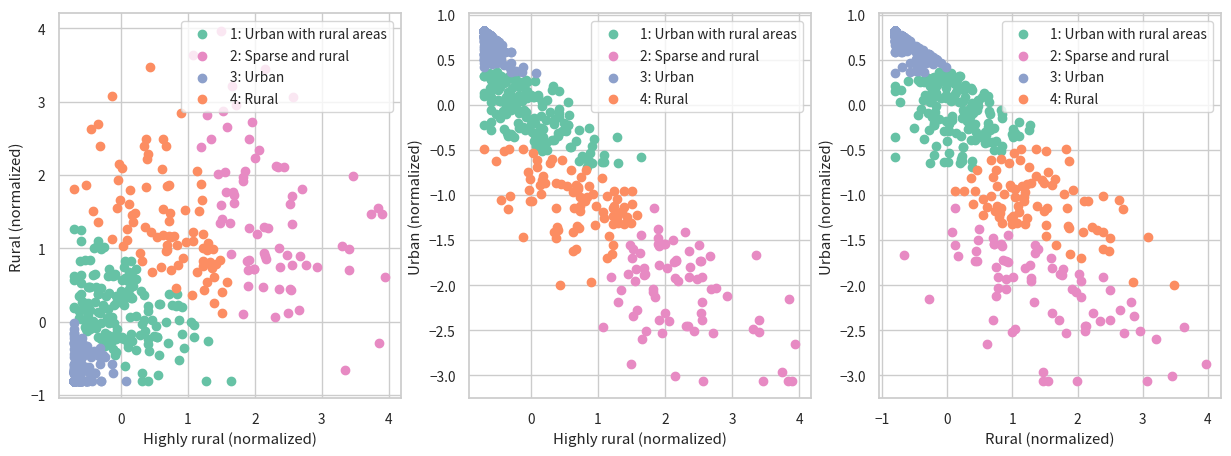

,count,%,random members
labels,,,
1: Urban with rural areas,155,23.8,"[UKPARL.2025.WRK, UKPARL.2025.COV, UKPARL.2025..."
2: Sparse and rural,74,11.4,"[UKPARL.2025.WAE, UKPARL.2025.NHR, UKPARL.2025..."
3: Urban,337,51.8,"[UKPARL.2025.TOO, UKPARL.2025.ISN, UKPARL.2025..."
4: Rural,84,12.9,"[UKPARL.2025.COR, UKPARL.2025.AAG, UKPARL.2025..."


In [6]:
c = (
    c.set_k(4)
    .set_anchor(Path("data", "interim", "con_2025_anchor.csv"))
    .add_labels(
        {1: "Urban with rural areas", 2: "Sparse and rural", 3: "Urban", 4: "Rural"}
    )
)
c.store_anchor(Path("data", "interim", "con_2025_anchor.csv"))
c.plot()
c.stats()

Assignment of leagues to groups for basic double check

In [7]:
name_lookup = get_dataset_df(
    repo="2025-constituencies",
    package="parliament_con_2025",
    version="latest",
    file="parl_constituencies_2025.csv",
).rename(columns={"short_code": "PARL25", "name": "constituency-name"})[
    ["PARL25", "nation", "constituency-name"]
]

d = df.reset_index()

d = d.merge(name_lookup, on="PARL25")

d["cluster"] = c.label_array(include_short=False)


d.pivot_table("PARL25", index="nation", columns="cluster", aggfunc="count").fillna(0)

cluster,Rural,Sparse and rural,Urban,Urban with rural areas
nation,,,,
England,70,46,309,118
Northern Ireland,3,8,3,4
Scotland,7,13,18,19
Wales,4,7,7,14


In [8]:
df["label"] = c.label_array(include_short=False)
final = df.reset_index()[["PARL25", "label"]].rename(
    columns={"label": "ruc-cluster-label"}
)
start_columns = ["PARL25"]
columns = [x for x in final.columns if x not in start_columns]
final = final[start_columns + columns]

final.to_csv(Path("data", "interim", "ruc_cluster_con_2025.csv"), index=False)

In [13]:
named_df = df.reset_index().merge(name_lookup, on="PARL25")

columns = ["PARL25", "constituency-name", "Highly rural", "Rural", "Urban", "label"]
named_df = named_df[columns]
named_df.columns = [x.lower().replace(" ", "_") for x in named_df.columns]
named_df.to_csv(Path("data", "packages", "uk_ruc", "pcon_2025_ruc.csv"), index=False)

In [ ]:
cluster_data = pd.read_csv(Path("data", "interim", "ruc_cluster_con_2025.csv"))
df = df.merge(cluster_data, on="pcon")
df.columns = [x.lower().replace(" ", "-") for x in df.columns]

name_lookup = (
    get_dataset_df(
        "uk_westminster_constituency_names_and_codes",
        "uk_westminster_constituency_names_and_codes",
        "latest",
        "constituencies_and_codes.csv",
    )
    .rename(columns={"gss-code": "pcon", "name": "constituency-name"})
    .drop(columns=["country", "mapit-id", "parliament-id"])
)

df = df.merge(name_lookup, on="pcon")
df = df.rename(columns={"pcon": "gss-code"})

start_columns = ["gss-code", "constituency-name"]

df = df[start_columns + [x for x in df.columns if x not in start_columns]]  # type: ignore
df.to_csv(Path("data", "packages", "uk_ruc", "pcon_ruc.csv"), index=False)